## Ансамбли
Пензин М.С.

penzin.ml.tsu@gmail.com

In [24]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
rcParams['figure.figsize'] = 12, 9

## Ансамбли

**Ансамбль**(фр. ensemble - совокупность, стройное целое) - это совокупность частей, образующих целое.

## Мудрость Толпы (Wisdom of crowds)

Френсис Галтон посетил как-то рынок скота, на котором около 800 человек пытались отгадать вес быка, стоявшего перед ними. Бык весил 1198 фунтов, но ни один человек не смог отгадать точный вес. При этом самое удивительное то, что если посчитать среднее от всех названных значений, то получится число очень близкое к реальному - 1197.

## Теорема Кондорсе о жюри присяжных

* N - число членов жюри
* p - вероятность правильного ответа одного члена жюри
* m - минимальное большинство членов жюри (обычно $\mathrm{floor}(N/2) + 1$)

Тогда вероятность правильного решения жюри

$$
\mu = \sum_{i=m}^{N} C_N^i p^i(1-p)^{N-i} \\
C_N^i = \frac{N!}{i!(N-i)!}
$$

$$
\mu = \sum_{i=m}^{N} C_N^i p^i(1-p)^{N-i}
$$

* если $p > 0.5$, то $\mu > p$
* если $N \to \infty$, то $\mu \to 1$

## Классификаторы

* __Слабый классификатор__ - это классификатор, который дает правильный ответ с вероятности, лишь немного превышающей вероятность простого угадывания.

* __Сильный классификатор__ - это классификатор, позволяющий добиться произвольно малой ошибки обучения.

## Голосование

* Простое голосование 
$$
    R(f_1(\vec{x}), \dotsc, f_M(\vec{x})) = \frac{1}{M} \sum_{m=1}^M f_m(\vec{x})
$$

* Взвешенное голосование
$$
    R(f_1(\vec{x}), \dotsc, f_M(\vec{x})) = \sum_{m=1}^M \omega_m f_m(\vec{x})
$$

* Смесь
$$
    R(f_1(\vec{x}), \dotsc, f_M(\vec{x})) = \sum_{m=1}^M g_m(\vec{x}) f_m(\vec{x})
$$

Хорошо, мы убелились, что ансамбли это хорошо, но у нас один набор данных, и, при этом, не всегда большой.

Также, у нас не так много методов, чтобы образовать многочисленное жюри.

## Bootstrap

Класс методов, основанных на многократной генерации выборок методом Монте-Карло на основе уже имеющейся выборки.

По сути, мы строим эмпирическое распределение на основе представленных данных. Далее, мы его используем для генерации значений случайной величины, распределенных по построенному распределению.

Практически, мы просто случайным образом выбираем объект из $\mathbf{X}$ с возвращением до тех пор, пока не получим выборку нужного размера (обычно того же, что и изначальная).

Можно проводить интервальную оценку параметров распределения

In [3]:
df = pd.read_csv("../data/mlbootcamp5_train.csv", 
                 sep=";", 
                 index_col="id")
weight = df['weight']

In [4]:
def bootstrap(data):
    idx = np.random.choice(data.index, size=len(data))
    return data[idx]


np.random.seed(13)
means = np.array([bootstrap(weight).mean() for _ in range(1000)])
print("mean interval: ", np.percentile(means, [1.0, 99.0]))

mean interval:  [74.08622087 74.32734226]


## Бэггинг

Bagging (от Bootstrap aggregation) - один из самых простых способов построения ансамбля.

1. Пусть у нас есть набор прецедентов $\mathbf{X}$ размером $N$.
2. Мы случайно выбираем из него $M$ элементов с возвращением, что в итоге дает нам новые подвыборки: $X_1, \dotsc, X_M$.
3. На каждом наборе $X_1, \dotsc, X_M$ мы обучаем наш алгоритм (базовые алгоритмы или слабые классификаторы), получая набор обученных моделей: $f_1(\vec{x}), \dotsc, f_M(\vec{x})$.
4. Итоговая классификация/регрессия - это простое голосование.

## Почему?

* благодаря разнообразию обученых моделей, их ошибки взаимно компенсируются при голосовании
* выбросы могут не попадать в некоторые обучающие подвыборки
* итоговая модель обладает меньшей дисперсией, по сравнению с отдельными базовыми моделями

## Пример

Рассмотрим задачу регрессии. Ошибка каждой модели $f_1, \dotsc, f_M$

$$
    \varepsilon_m(\vec{x}_n) = y_n - f_m(\vec{x}_n)
$$

Результат голосования представим в виде

$$
    \bar{y}_n = \frac{1}{M} \sum_m f_m(\vec{x}_n)
$$

Найдем среднеквадратичное отклонение для итоговой модели регрессии
$$
\begin{align}
    D &= E_n\left[
        \left(
            \frac{1}{M} \sum_m f_m(\vec{x}_n) - y_n
        \right)^2
    \right] \\
    & = E_n\left[
        \left(
            \frac{1}{M} \sum_m \varepsilon_m(\vec{x}_n)
        \right)^2
    \right]
\end{align}
$$

Предположим, что 

* ошибки несмещены ($E_n[\varepsilon_m(\vec{x}_n)] = 0$) 
* ошибки некоррелированы ($E_n[\varepsilon_m(\vec{x}_n) \varepsilon_k(\vec{x}_n)] = 0, \forall m \ne n$)

$$
\begin{align}
    D &= 
    E_n\left[
        \left(
            \frac{1}{M} \sum_m \varepsilon_m(\vec{x}_n)
        \right)^2
    \right]
    \\
    &=
    \frac{1}{M^2} E_n\left[
        \sum_m \varepsilon^2_m(\vec{x}_n)
        +
        \sum_{m \ne k} C_{mk} \varepsilon_m(\vec{x}_n) \varepsilon_k(\vec{x}_n)
    \right]
    \\
    &=
    \frac{1}{M^2} E_n\left[
        \sum_m \varepsilon^2_m(\vec{x}_n)
    \right]
    =
    \frac{1}{M} \frac{1}{M}     
        \sum_m E_n\left[\varepsilon^2_m(\vec{x}_n)\right]    
\end{align}
$$

$$
D =  \frac{1}{M} \left( \frac{1}{M}     
        \sum_m E_n\left[\varepsilon^2_m(\vec{x}_n)\right]    \right)
$$

Отсюда видно, что средняя ошибка ансамбля в $M$ раз меньше, чем средняя ошибка всех моделей.

## Из чего состоит ошибка

$$
    y(\vec{x}) = f(\vec{x}) + \varepsilon(\vec{x}) \\
    \varepsilon \sim N(0, \sigma^2), y \sim N(f(\vec{x}), \sigma)
$$

$$
\begin{align}
    \mathrm{Err}(\vec{x})
    &= 
    E \left[
        \left(
            y(\vec{x}) - \bar{f}(\vec{x})
        \right)^2
    \right]
    \\&=
    E [y^2] - E[y]^2 + E[y]^2
    + E[\bar{f}^2] - E[\bar{f}^2]^2 + E[\bar{f}^2]^2
    - 2 E[y \bar{f}]
    \\&=
    \sigma^2 + f^2 + D[\bar{f}] 
    + E[\bar{f}]^2 
    - 2 f E[\bar{f}] 
    \\&=
    (E[f - \bar{f}])^2 + D[\bar{f}] + \sigma^2 
    \\&=
    \mathrm{Bias} (\bar{f})^2 + D[\bar{f}] + \sigma^2 
\end{align}
$$

<center>
    <img src="bv_all.jpg">
</center>

$$
\begin{align}
    \mathrm{Err}(\vec{x}) = \mathrm{Bias} (\bar{f})^2 + D[\bar{f}] + \sigma^2 
\end{align}
$$

Здесь мы можем повлиять только на $\mathrm{Bias} (\bar{f})^2$ и $D[\bar{f}]$.

## sklearn

В **sklearn** уже реализованы __BaggingClassifier__ и **BagginRegressor**, которые могут использовать большинство других алгоритмов.

Приведем пример из __[документации sklearn](https://scikit-learn.org/stable/auto_examples/ensemble/plot_bias_variance.html)__

Tree: 0.0255 (error) = 0.0003 (bias^2)  + 0.0152 (var) + 0.0098 (noise)

Bagging: 0.0196 (error) = 0.0004 (bias^2)  + 0.0092 (var) + 0.0098 (noise)

<img src="bagging.png"></img>

## Метод случайных подпространств

**Random subspace method(RSM)** - в данном методе алгоритмы обучаются на различных подмножествах признаков, которые формируются случайным образом.

Может быть эффективен при большом числе признаков, небольшом числе объектов или наличие малоинформативных признаков.

## Случайный лес

Дерево решений является очень хорошим семейством базовых классификаторов, для бэггинга.

1. Пусть $K$ - число признаков, $M$ - число выборок сгенерированных с помощью бутстрапа: $X_1, \dotsc, X_m$.
2. Построить дерево решений (обычно максимальной глубины) для каждого $X_m$, используя при каждом разбиении только $k$ случайных признаков из $K$.
3. Для определение принадлежности прецедента к какому либо классу, проводится голосование среди $M$ - базовых моделей.

## Out-of-bag error

Пусть у нас есть выборка из $N$ объектов. Следовательно вероятность достать из неё любой объект - это $\frac{1}{N}$. Нам нужно собрать новую подвыборку размером $N$ доставая из ней объекты с возвращением.

Посчитаем вероятность того, что объект не попадет в подвыборку, что соответствует тому, что объект не взяли $N$ раз.
$$
p = \left( 
    1 - \frac{1}{N}
\right)^N
$$

$$
p = \lim_{N \to \infty} \left( 
    1 - \frac{1}{N}
\right)^N = \frac{1}{e}
$$

из чего следует, что вероятность того, что конкретный объект попадет в подвыборку
$$
p \approx 63 \%
$$

Отсюда следует, что в среднем $37 \%$ при бутстрапе остается в выборке, а значит мы можем использовать этот остаток для проверки нашей модели.

## sklearn

В **sklearn** уже рализованы алгоритмы случайного леса __RandomForestClassifier__ и **RandomForestRegressor**.

* n_estimators - число деревье
* max_depth - максимальная глубина дерева
* oob_score - рассчитывать ли out-of-bag error

In [5]:
np.random.seed(13)

f = lambda x: np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)
x_train = np.random.uniform(-5, 5, 200); 
x_train.sort()

x_test = np.random.uniform(-5, 5, 1000); 
x_test.sort()

y_train = f(x_train) + np.random.normal(0, 0.1, x_train.shape)
x_train = x_train.reshape( (200, -1) )

y_test = f(x_test) + np.random.normal(0, 0.1, x_test.shape)
x_test = x_test.reshape( (1000, -1) )

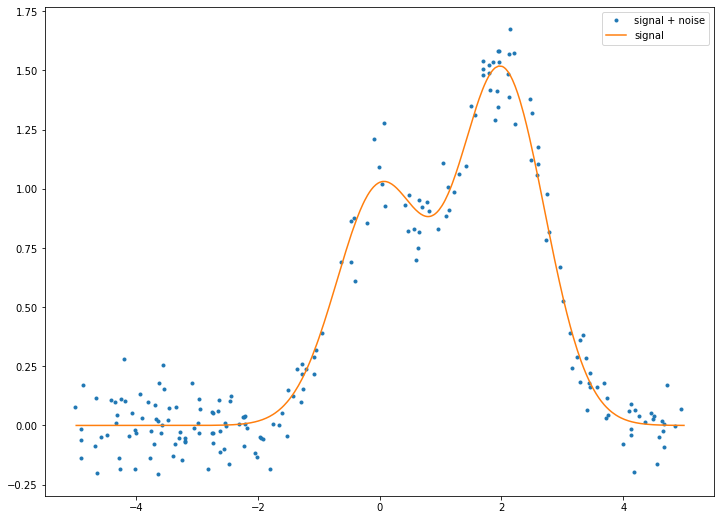

In [6]:
plt.plot(x_train.ravel(), y_train, ".", label="signal + noise")
plt.plot(x_test.ravel(), f(x_test), "-", label="signal")
plt.legend();

In [7]:
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor().fit(x_train, y_train)
predict_tree = tree.predict(x_test)

bag = BaggingRegressor(
    DecisionTreeRegressor(), n_estimators=50).fit(x_train, y_train)
predict_bag = bag.predict(x_test)

rf = RandomForestRegressor(n_estimators=50).fit(x_train, y_train)
predict_rf = rf.predict(x_test)

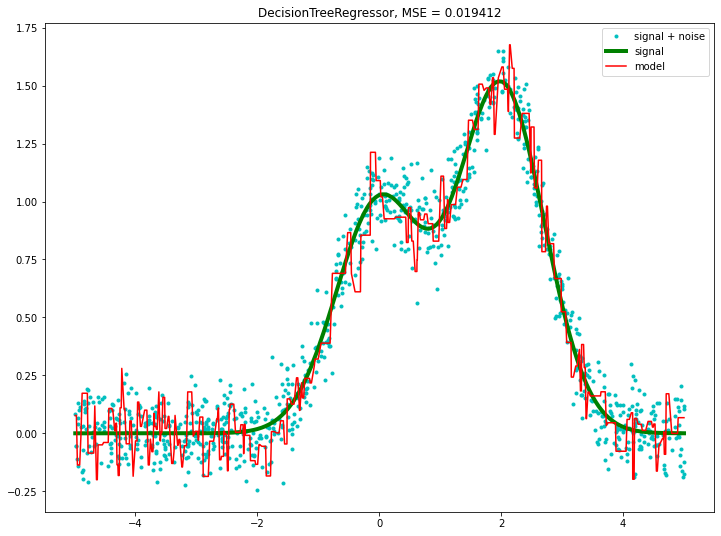

In [8]:
mse = ((y_test - predict_tree)**2).sum() / y_test.shape[0]
plt.title("DecisionTreeRegressor, MSE = %f" % mse)
plt.plot(x_test, y_test, "c.", label="signal + noise")
plt.plot(x_test, f(x_test), "g", lw=4, label="signal")
plt.plot(x_test.ravel(), predict_tree, "r", label="model")
plt.legend();

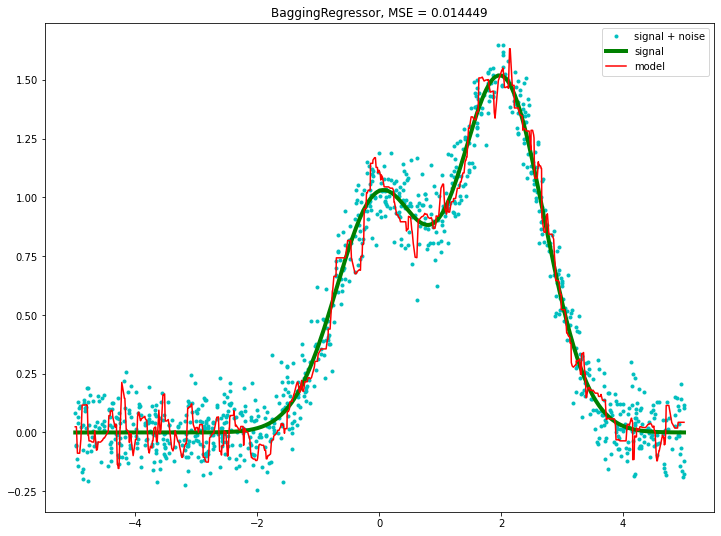

In [9]:
mse = ((y_test - predict_bag)**2).sum() / y_test.shape[0]
plt.title("BaggingRegressor, MSE = %f" % mse)
plt.plot(x_test, y_test, "c.", label="signal + noise")
plt.plot(x_test, f(x_test), "g", lw=4, label="signal")
plt.plot(x_test.ravel(), predict_bag, "r", label="model")
plt.legend();

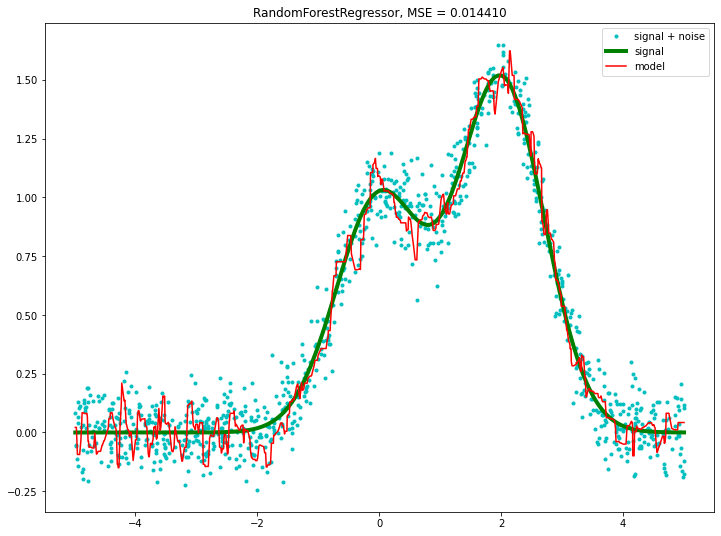

In [10]:
mse = ((y_test - predict_rf)**2).sum() / y_test.shape[0]
plt.title("RandomForestRegressor, MSE = %f" % mse)
plt.plot(x_test, y_test, "c.", label="signal + noise")
plt.plot(x_test, f(x_test), "g", lw=4, label="signal")
plt.plot(x_test.ravel(), predict_rf, "r", label="model")
plt.legend();

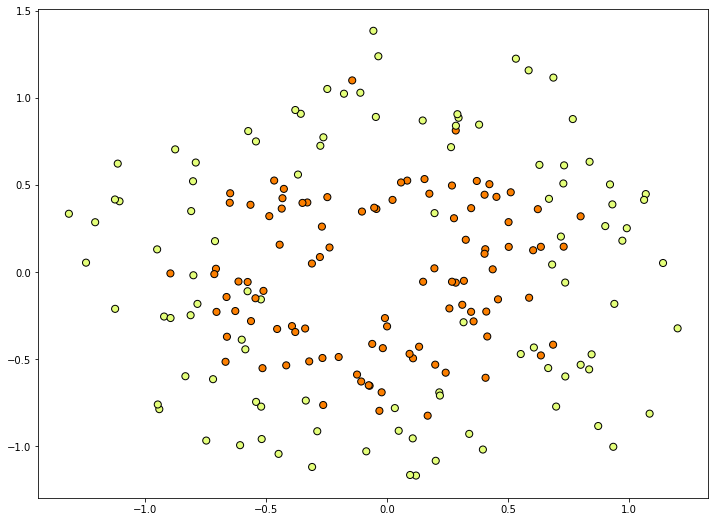

In [11]:
from sklearn.datasets import make_circles, make_moons
np.random.seed(13)
#X, Y = make_circles(200, noise=0.2)
X, Y = make_circles(200, factor=0.5, noise=0.2)
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.get_cmap("Wistia"), 
            edgecolors='k', s=50)
plt.show()

In [12]:
def plot(clf, X, Y):
    clf.fit(X, Y)
    
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    dx = (x_max - x_min) * 0.1
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    dy = (y_max - y_min) * 0.1
    xx, yy = np.meshgrid(np.linspace(x_min - dx, x_max + dx, 100),
                        np.linspace(y_min - dy, y_max + dy, 100))
    Z = clf.predict(np.stack([xx.ravel(), yy.ravel()], axis=1))
    Z = Z.reshape(xx.shape)

    plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Wistia)
    plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.get_cmap("Wistia"), 
            edgecolors='k', s=50)
    
    plt.show()

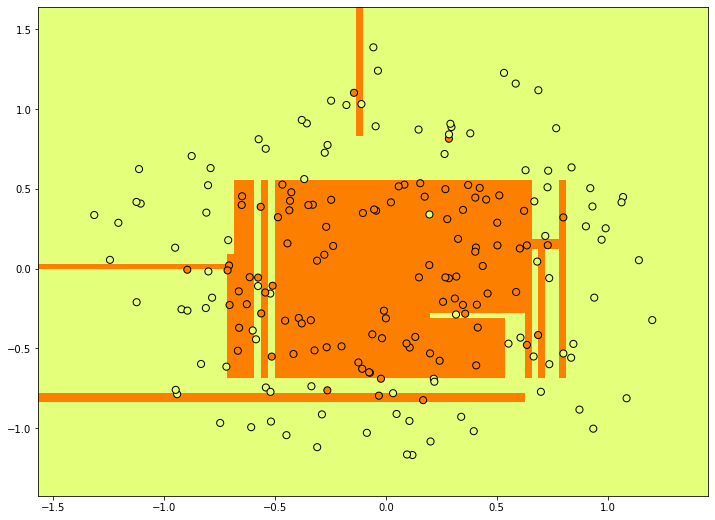

In [13]:
from sklearn.tree import DecisionTreeClassifier

plot(DecisionTreeClassifier(), X, Y)

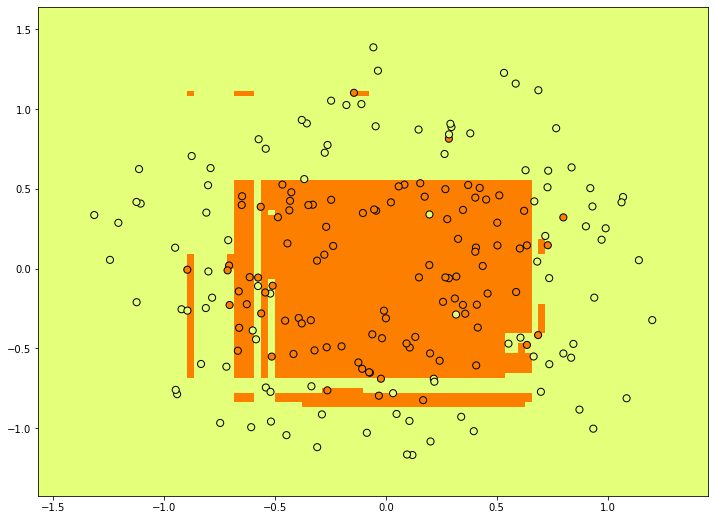

In [14]:
from sklearn.ensemble import BaggingClassifier

plot(BaggingClassifier(DecisionTreeClassifier()), X, Y)

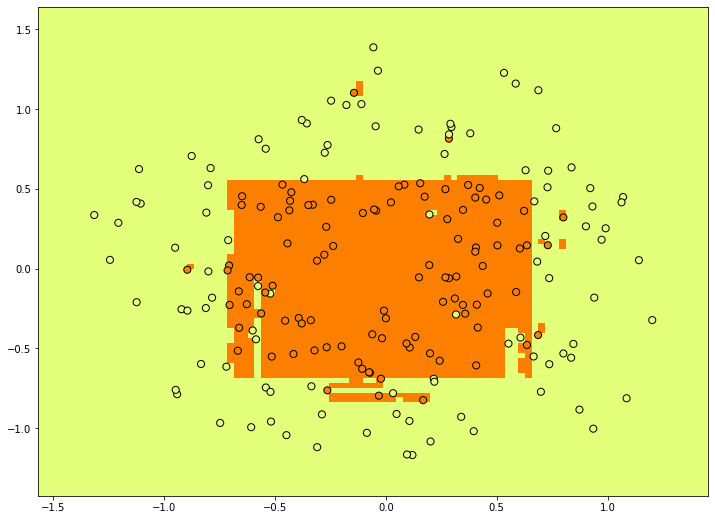

In [43]:
from sklearn.ensemble import RandomForestClassifier

plot(RandomForestClassifier(), X, Y)

## Пример

In [15]:
df = pd.read_csv("../data/mlbootcamp5_train.csv", 
                 sep=";", 
                 index_col="id")
# Делаем one-hot кодирование
chol = pd.get_dummies(df["cholesterol"], prefix="chol")
gluc = pd.get_dummies(df["gluc"], prefix="gluc")
df = pd.concat([df, chol, gluc], axis=1)

# Делаем пол бинарным признаком
df["gender_bin"] = df["gender"].map({1: 0, 2: 1})

# Чистим от плохих данных
df = df[(df["age"] > 12500)&
        (df["weight"] > 40)&(df["weight"] < 105)&
        (df["height"] > 140)&(df["height"] < 190)&
        (df["ap_lo"] > 60)&(df["ap_lo"] < 110)&
        (df["ap_hi"] > 80)&(df["ap_hi"] < 170)
     ]

In [16]:
from sklearn.model_selection import cross_validate, StratifiedKFold

features = ["age", "weight", "height", "ap_hi", "ap_lo", 
           "gender_bin",
           "chol_1", "chol_2", "chol_3",
           "gluc_1", "gluc_2", "gluc_3"]

data = df[features].values
target = df['cardio'].values

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)

In [19]:
from sklearn.ensemble import RandomForestClassifier

n_estimators = np.arange(5, 50, 5)
train_acc = np.zeros((n_estimators.shape[0], skf.get_n_splits()))
test_acc = np.zeros((n_estimators.shape[0], skf.get_n_splits()))

for i, n in enumerate(n_estimators):
    rf = RandomForestClassifier(
        n_estimators=n, random_state=13)
    results = cross_validate(rf, data, target, cv=skf, scoring="accuracy", return_train_score=True)
    train_acc[i] = results["train_score"]
    test_acc[i] = results["test_score"]

In [20]:
def plot(param, train_score, test_score):
    train_mean = train_score.mean(axis=1)
    train_std = train_score.std(axis=1)
    
    test_mean = test_score.mean(axis=1)
    test_std = test_score.std(axis=1)
    
    plt.plot(param, train_mean, "g-", label="train_score")    
    plt.plot(param, test_mean, "r-", label="test_score")
    plt.legend()
    plt.show()

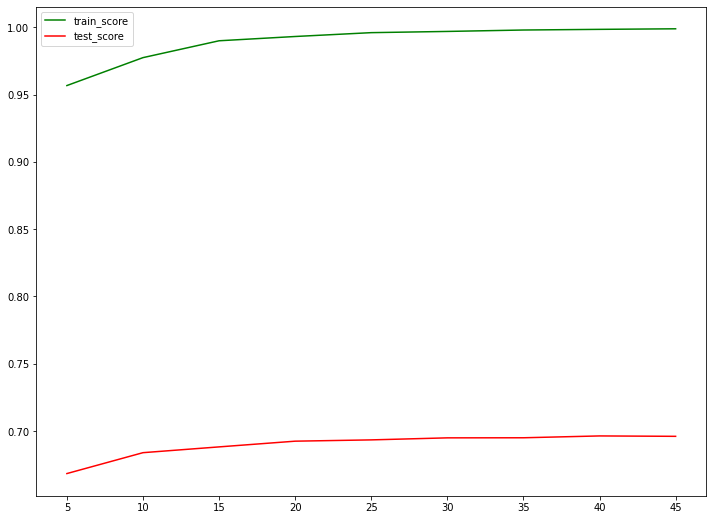

In [22]:
plot(n_estimators, train_acc, test_acc)

In [23]:
# А еще мы можем оценить важность признаков

rf = RandomForestClassifier(30)
rf.fit(data, target)
feature_importances = pd.DataFrame(zip(features, rf.feature_importances_),
                                  columns=["Name", "Importance"])
feature_importances.sort_values(by="Importance", ascending=False)

,Name,Importance
0,age,0.362969
1,weight,0.178803
3,ap_hi,0.166356
2,height,0.164487
4,ap_lo,0.070421
8,chol_3,0.015502
6,chol_1,0.013219
5,gender_bin,0.011865
9,gluc_1,0.005016
7,chol_2,0.004508


## Сверхслучайные деревья

Для тех, кому не достаточно случайности, можно использовать сверхслучайные деревья. В них порог для разбиения выбирается случайным образом. Позволяют уменьшить дисперсию, но ценой роста смещения.

В библиотеке sklearn они представлены классами __ExtraTreesClassifier__ и **ExtraTreesRegressor**.

## Плюсы случайного леса

* высокая точность предсказания, немного лишь уступающая бустингу
* не очень чувствителен к выбросам
* также, как и обычные деревья, не чувствителен к масштабу признаков
* весьма хорошо работает из коробки
* эффективно работает с большим числом признаков и классов
* сложно переобучить
* имеется возможность оценки важности признаков
* возможно распараллелить

## Минусы случайного леса

* хуже работет в случае разреженных признаков
* также, как и обычные деревья, не умеет экстраполировать
* склонен к переобучению на зашумленных данных
* большой размер модели

## Стэкинг (stacking)

Stacking - использует подход мета-классификации. Мы строим новую модель поверх множества моделей, и данная модель сама определяет наилучшую комбинацию базовых моделей.

 * Пусть $\mathrm{X}$ - обучающая выборка, $f_1,\dotsc, f_M$ - базовые классификаторы
 * Формируем мета-классификатор, признаками для которого становятся метки классов, возвращаемые базовыми алгоритмами $f_1,\dotsc, f_M$

## Вариант 1 (Стекинг)

1. Делим обучающую выборку $\mathrm{X}$ на две подвыборки $\mathrm{X}_1$ и $\mathrm{X}_2$ (можно разбить и на большее количество фолдов).
2. Обучаем базовые модели на $\mathrm{X}_1$ и делаем предсказания на $\mathrm{X}_2$. 
3. Обучаем те же базовые модели на $\mathrm{X}_2$ и делаем предсказания на $\mathrm{X}_1$.
4. Обучаем базовые модели на $\mathrm{X}$ и делаем предсказания на тестовой выборке.
5. Обучаем мета-модель на результатах (вероятностях) базовых моделей полученных в шаге 2 и 3.
6. Делаем предсказание мета-модели на данных с шага 4. Сравниваем результаты с истинными значениями тестовой выборки. 

Иногда к признакам для мета-модели добавляют обычные признаки для базовых моделей.

## Вариант 2 (Блендинг)

1. Делим обучающую выборку на основную $\mathrm{X}_m$ и на отложенную $\mathrm{X}_h$(обычно порядка 10% от обучающей выборки).
2. Обучают несколько моделей на $\mathrm{X}_m$. Делают предсказания $\mathrm{P_h}$ на отложенной выборке $\mathrm{X}_h$ и на тестовой выборке
3. Обучаем мета-модель на $\mathrm{P_h}$ и проверяем на предсказаниях, используя тестовую выборку

и множество их вариаций...

Для того, чтобы стекинг работал, нужны достаточно большие выборки объектов, хотя и на малых выборках иногда может давать хороших ответ.

А можно ли "стекать" несколько уровней моделей?